In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math
from quantile_forest import RandomForestQuantileRegressor

# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
output_folder = '/mnt/primus/xuemeng_tmp_harbour/soc/results'

In [2]:
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

def quantile_cross_val_predict(estimator, X, y, cv, quantiles, groups=None):
    """ Custom cross-validation to handle quantile predictions with group support. """
    predictions = {q: [] for q in quantiles}
    if groups is None:
        cv_split = cv.split(X)
    else:
        cv_split = cv.split(X, y, groups)
    
    for train_idx, test_idx in cv_split:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        
        # Fit the model on the training data
        estimator.fit(X_train, y_train)
        
        # Predict each quantile and store results
        for q in quantiles:
            pred = estimator.predict(X_test, quantiles=q)
            predictions[q].extend(pred)
    
    return predictions

In [3]:
# a = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/', 'model_rf.*.ccc.joblib')
# a = [str(i) for i in a]

prop = 'oc'
file_rf = '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/model_rf.CEC_log1p.ccc.joblib'

results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

covs_a = pd.read_csv(f'{output_folder}/{prop}/benchmark_selected.covs_{prop}.txt').values.tolist()
covs = [item for sublist in covs_a for item in sublist]
    
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

rf_model = joblib.load(file_rf)
rf_model.n_jobs = 90

params = rf_model.get_params()
# params['n_jobs'] = 90
qrf = RandomForestQuantileRegressor(**params)

### quantile random forest - metrics
- cv
- individual test

In [1]:


quantiles = [0.05, 0.95]
ttprint(f'quantile, cv, {prop}')
predictions = quantile_cross_val_predict(qrf, train[covs], train[prop], cv, quantiles, groups = train[spatial_cv_column])
picp_cv = calc_picp(np.array(predictions[quantiles[0]]), np.array(predictions[quantiles[1]]), train[prop])
    
qcp_cv_lower = calc_qcp(np.array(predictions[quantiles[0]]), train[prop], quantiles[0])
qcp_cv_upper = calc_qcp(np.array(predictions[quantiles[1]]), train[prop], quantiles[1])
    
piw_cv = np.mean(np.array(predictions[quantiles[1]])-np.array(predictions[quantiles[0]]))

    
ttprint(f'quantile, individual test, {prop}')
qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)
picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    
qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    
piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    
results.append({
    'property': 'qrf',
    'picp': picp_test,
    'piw': piw_test,
    'qcp05': qcp_test_lower,
    'qcp95': qcp_test_upper
})
    

### accuracy plot
predicted quantile VS. real quantile

In [4]:
import numpy as np
quantiles = [0.005, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.995]

qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)

/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [5]:

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_pred_test[:,ii], test[prop], quantiles[ii]))

pi = []
picp = []
piw = []
for ii in range(11):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_pred_test[:,ii], y_pred_test[:,jj], test[prop]))
    piw.append(np.mean(y_pred_test[:,jj]-y_pred_test[:,ii]))


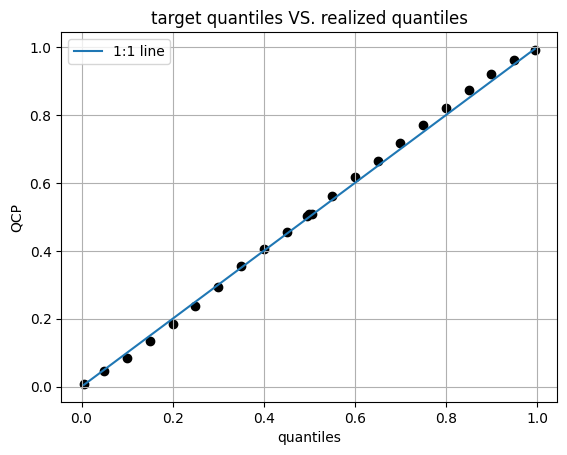

In [6]:
fig, ax = plt.subplots()
ax.plot(quantiles, quantiles, label='1:1 line')
ax.scatter(quantiles, qcp, color='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('QCP')
ax.set_title('target quantiles VS. realized quantiles')
ax.grid(True)
plt.legend()
plt.show()

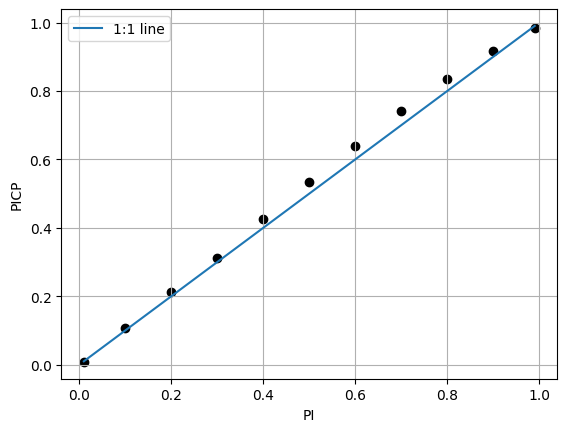

In [7]:
fig, ax = plt.subplots()
ax.plot(pi, pi, label='1:1 line')
ax.scatter(pi, picp, color='black')
ax.set_xlabel('PI')
ax.set_ylabel('PICP')
ax.grid(True)
plt.legend()
plt.show()

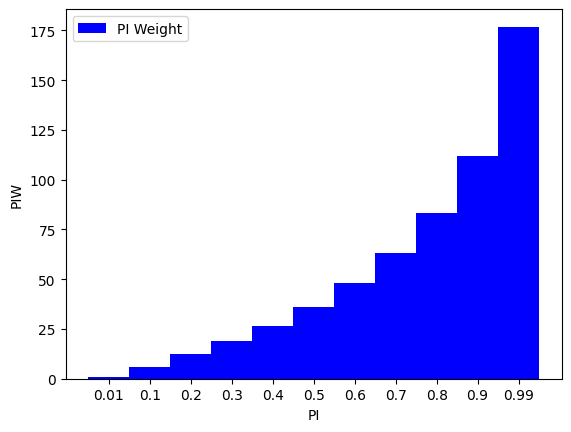

In [8]:
x_positions = list(range(len(piw), 0, -1))

fig, ax = plt.subplots()
ax.bar(x_positions, piw, width=1, color='blue', label='PI Weight')
ax.set_xticks(x_positions)  # Set x-ticks at the positions listed in `pi`
ax.set_xticklabels([f'{p}' for p in pi])
ax.set_xlabel('PI')
ax.set_ylabel('PIW')
# ax.grid(True)
plt.legend()
plt.show()

### validate on validation set time series

In [9]:
test['oc_quantile.95'] = y_pred_test[:,-2]
test['oc_quantile.05'] = y_pred_test[:,1]

In [11]:
data = test[test['hzn_dep'] == 10]
columns_of_interest = ['id', 'time', 'oc', 'oc_quantile.95', 'oc_quantile.05']
data = data[columns_of_interest]

data

,id,time,oc,oc_quantile.95,oc_quantile.05
1,56922206,2009.0,6.5,28.420,6.4000
3,56882134,2009.0,14.8,45.725,8.3000
4,56722160,2009.0,15.6,30.640,8.2450
5,56302122,2009.0,7.9,25.230,5.2000
6,55682118,2009.0,4.7,22.675,5.2000
...,...,...,...,...,...
4540,34923790,2018.0,28.9,102.945,9.5335
4541,34983770,2018.0,19.1,130.650,9.8850
4542,34443626,2018.0,34.6,148.928,23.8500
4543,35483702,2018.0,44.1,301.185,22.8750


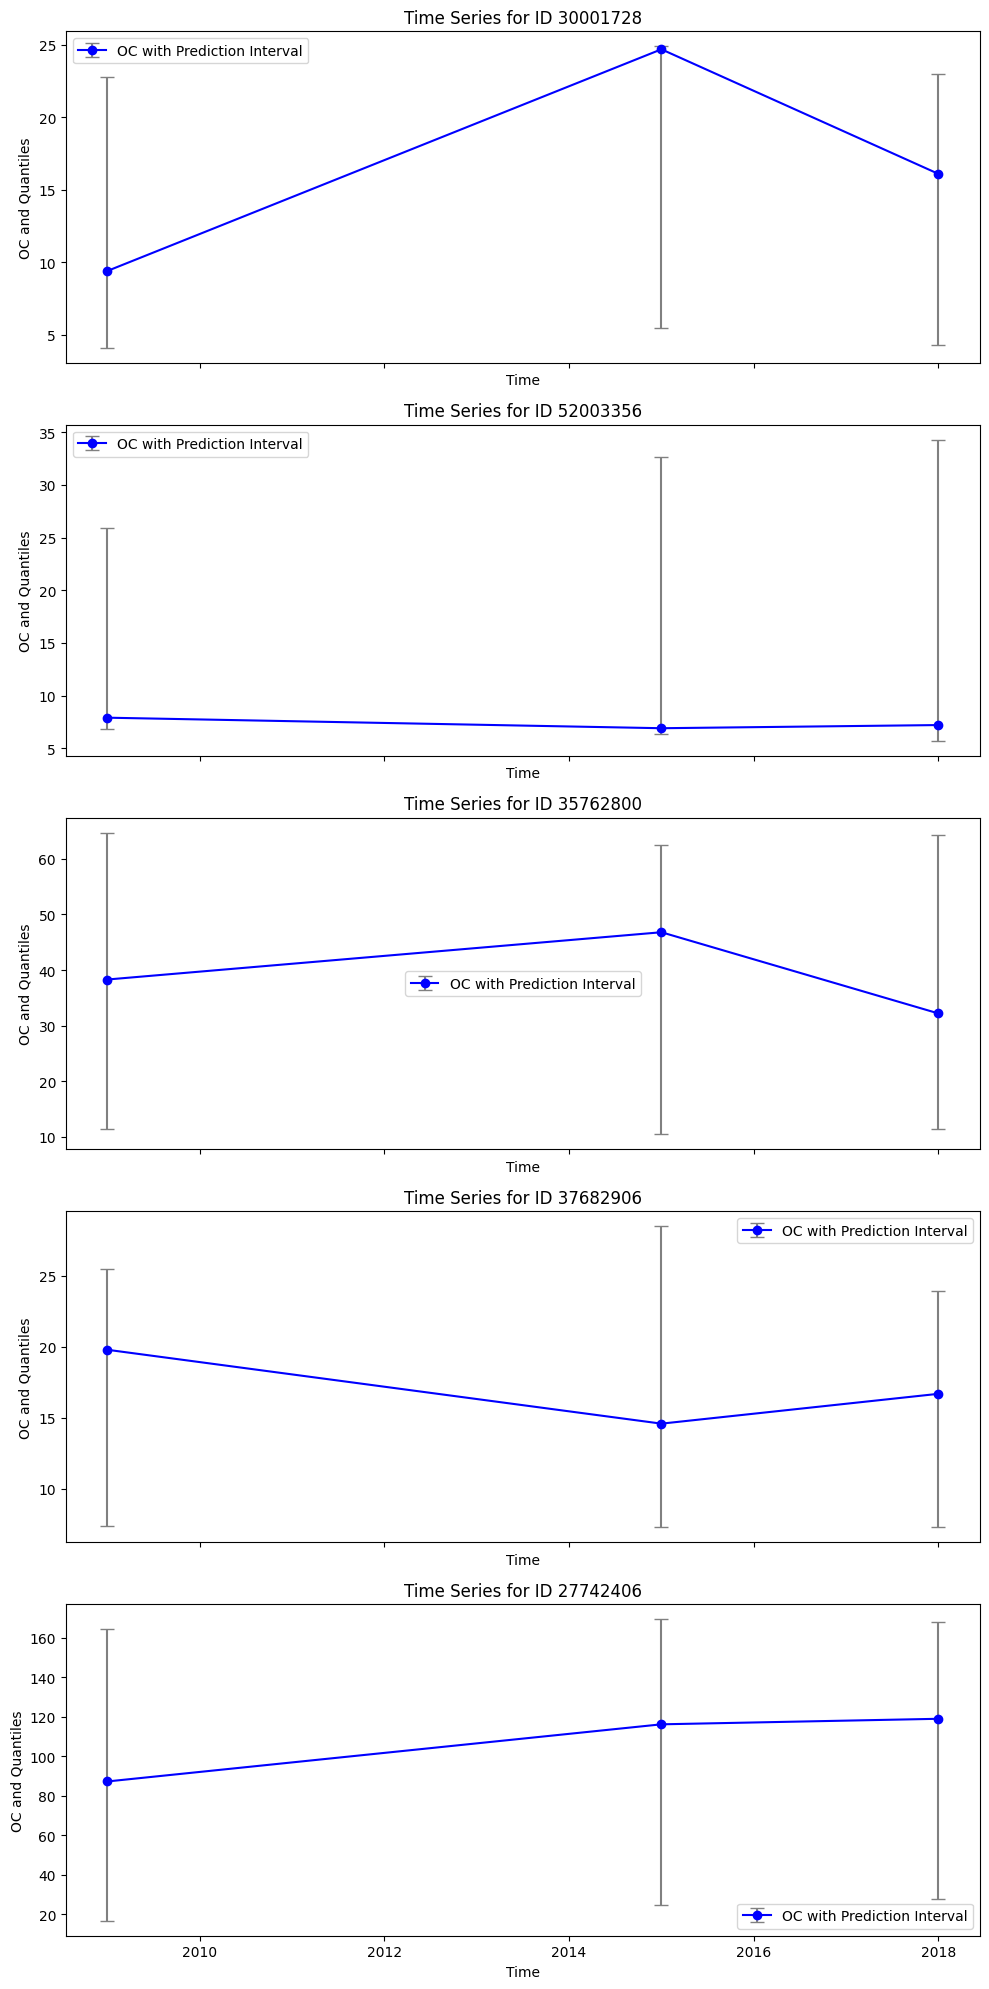

In [13]:
sample_ids = np.random.choice(data['id'].unique(), size=5, replace=False)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=1, figsize=(10, 20), sharex=True)

for i, sample_id in enumerate(sample_ids):
    sample_data = data[data['id'] == sample_id].sort_values('time')
    
    # Using error bars to represent quantiles instead of fill_between
    axes[i].errorbar(sample_data['time'], sample_data['oc'], 
                     yerr=[sample_data['oc'] - sample_data['oc_quantile.05'], sample_data['oc_quantile.95'] - sample_data['oc']], 
                     fmt='o', linestyle='-', color='blue', ecolor='gray', capsize=5, label='OC with Prediction Interval')
    
    axes[i].set_title(f'Time Series for ID {sample_id}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('OC and Quantiles')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [20]:
def check_non_overlapping_intervals(data):
    data = data.sort_values('time')
    for i in range(len(data) - 1):
        if not (data.iloc[i]['oc_quantile.95'] < data.iloc[i + 1]['oc_quantile.05'] or
                data.iloc[i]['oc_quantile.05'] > data.iloc[i + 1]['oc_quantile.95']):
            return False
    return True

non_overlapping_ids = []
for id, group in test[test['hzn_dep'] == 10].groupby('id'):
    if len(group['time'].unique()) > 1 and check_non_overlapping_intervals(group):
        non_overlapping_ids.append(id)


In [21]:
import matplotlib.pyplot as plt

for sample_id in non_overlapping_ids:
    sample_data = test[test['id'] == sample_id].sort_values('time')
    plt.figure(figsize=(10, 4))
    plt.fill_between(sample_data['time'], sample_data['oc_quantile.05'], sample_data['oc_quantile.95'], color='gray', alpha=0.5)
    plt.plot(sample_data['time'], sample_data['oc'], marker='o', linestyle='-', color='blue')
    plt.title(f'Time Series for ID {sample_id}')
    plt.xlabel('Time')
    plt.ylabel('OC and Quantiles')
    plt.show()

In [24]:
non_overlapping_ids

[]

In [18]:
test.loc[test['id']==48544672]

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_trachyte,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep,oc_log1p,oc_quantile.95,oc_quantile.05
4481,48544672,64.769362,21.186397,2018.0,LUCAS,SE,499.3,3.8,3.1,NaN,...,0,0,0,0,1,0,10.0,6.215208,496.325,9.99
